In [1]:
# import libraries.

import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
import random

from sklearn.model_selection import train_test_split,cross_val_score,GridSearchCV
from sklearn.preprocessing import StandardScaler,OneHotEncoder,PolynomialFeatures
from sklearn.impute import SimpleImputer
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.svm import SVR
from sklearn.linear_model import LinearRegression,Ridge,SGDRegressor
from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.ensemble import VotingRegressor, StackingRegressor
from sklearn.metrics import mean_squared_error,r2_score,mean_absolute_error

In [2]:
# 1.Load Data-set

df=pd.read_csv("https://raw.githubusercontent.com/asadaladil/PHITRON_Resources/refs/heads/main/Exams/6.%20AL-ML/2.%20Machine%20Learning%20Course/4.%20Final%20Exam/insurance.csv")

print("First 5 records:\n", df.head())
print(df.shape)

First 5 records:
    age     sex     bmi  children smoker     region      charges
0   19  female  27.900         0    yes  southwest  16884.92400
1   18    male  33.770         1     no  southeast   1725.55230
2   28    male  33.000         3     no  southeast   4449.46200
3   33    male  22.705         0     no  northwest  21984.47061
4   32    male  28.880         0     no  northwest   3866.85520
(1338, 7)


In [3]:
print(df.isnull().sum())

age         0
sex         0
bmi         0
children    0
smoker      0
region      0
charges     0
dtype: int64


In [4]:
# target splitting
X=df.drop('charges',axis=1)
y=df['charges']


# i) Feature Engineering:
def age_group(age):
    if age<18:
        return 'Child'
    elif age>=18 and age<50:
        return 'Adult'
    else:
        return 'Senior'


X['age_group']=X['age'].apply(age_group)
determiner=y.sum()/(df.shape[0]*df.shape[1])

def income(i):
  return i*determiner+y.mean()

X['income']=X['bmi'].apply(income)+X['children']*1500

# numeric and categorical splitting
numeric=X.select_dtypes(include=['int64', 'float64']).columns
categorical=X.select_dtypes(include=['object']).columns


# ii) Missing value handling (Numeric and categorical)
# iii) Scaling (Numeric)
# iv) Encoding (Categorical)
numeric_X=Pipeline(
    steps=[
          ('imputer',SimpleImputer(strategy='mean')),
          ('scaler',StandardScaler())
          ]
    )
categorical_X=Pipeline(
    steps=[
          ('imputer',SimpleImputer(strategy='most_frequent')),
          ('encoder',OneHotEncoder(handle_unknown='ignore'))
          ]
    )

# v) Outlier handing
X['income']=np.log(X['income'])

# 2. Preprocessing:

preprocessor=ColumnTransformer(
    transformers=[
                  ('num', numeric_X, numeric),
                  ('cat', categorical_X, categorical)
                 ]
    )


In [5]:
# Splitting
X_train,X_test,y_train,y_test = train_test_split(
    X,y, test_size=0.2, random_state=42
)
print(X_train.head())

      age     sex    bmi  children smoker     region age_group     income
560    46  female  19.95         2     no  northwest     Adult  10.898425
1285   47  female  24.32         0     no  northeast     Adult  10.991640
1142   52  female  24.86         0     no  southeast    Senior  11.008734
969    39  female  34.32         5     no  southeast     Adult  11.360164
486    54  female  21.47         3     no  northwest    Senior  10.976315


In [6]:
# Model declaration

rfr_model=RandomForestRegressor(n_estimators=100,random_state=42)
lr_model=LinearRegression()
sgd_model=SGDRegressor(max_iter=1000,random_state=42)
poly_model=Pipeline([
    ('poly',PolynomialFeatures(degree=3)),
    ('model',lr_model)
])
svr_model=SVR(kernel='rbf')
gbr_model=GradientBoostingRegressor(n_estimators=100,random_state=42)

In [7]:
#Voting regressor

voting_reg=VotingRegressor(
    estimators= [
        ('lr', lr_model),
        ('rf',rfr_model),
        ('gb', gbr_model),
        ('svr', svr_model),
        ('sgd', sgd_model),
        ('poly', poly_model),

    ]
)

#stacking

stacking_reg=StackingRegressor(
    estimators= [
        ('lr', lr_model),
        ('rf',rfr_model),
        ('gb', gbr_model),
        ('svr', svr_model),
        ('sgd', sgd_model),
        ('poly', poly_model),
    ],
    final_estimator=Ridge()
)


In [8]:
# list of model
models={
    'Linear Regression':lr_model,
    'Random Forest':rfr_model,
    'SGD Regressor':sgd_model,
    'Polynomial Regression':poly_model,
    'Support Vector Regression':svr_model,
    'Gradient Boosting':gbr_model,
    'Voting Ensemble':voting_reg,
    'Stacking Ensemble':stacking_reg

}

In [9]:
# 3. Finding best model

result=[]
for name,model in models.items():
  pipe=Pipeline(
      [
          ('preprocessor',preprocessor),
          ('model',model)
      ]
  )

  pipe.fit(X_train,y_train)
  y_pred=pipe.predict(X_test)

  r2=r2_score(y_test,y_pred)
  rmse=np.sqrt(mean_squared_error(y_test,y_pred))
  mae=mean_absolute_error(y_test,y_pred)

  result.append({
      "Model":name,
      "R2 Score":r2,
      "RMSE":rmse,
      "MAE":mae
  })

results_df=pd.DataFrame(result).sort_values("R2 Score",ascending=False)

print(results_df)

                       Model  R2 Score          RMSE          MAE
7          Stacking Ensemble  0.881103   4296.340314  2360.941149
5          Gradient Boosting  0.878281   4347.040020  2450.685991
1              Random Forest  0.864038   4594.332997  2509.180064
6            Voting Ensemble  0.838664   5004.720120  3261.313539
2              SGD Regressor  0.788081   5735.868921  4102.961519
0          Linear Regression  0.785705   5767.928759  4216.616579
3      Polynomial Regression  0.726365   6517.782706  3349.955175
4  Support Vector Regression -0.070311  12890.477269  8602.490609


In [10]:
# 4. Best Model

best_model_name=results_df.iloc[0]['Model']
best_model_obj=models[best_model_name]

print(best_model_name)

Stacking Ensemble


- Based on R2 score, RMSE score, MAE score. I have chosen the Gradient Boosting Regressor model from results_df for easily hyper-parameter tuning and further estimation and cross validation with GridSearchCV technique.

In [11]:
# 5. Model Training
final_model=Pipeline([
    ('preprocessor', preprocessor),
    ('model',best_model_obj)
])

final_model.fit(X_train,y_train)
y_pred=final_model.predict(X_test)

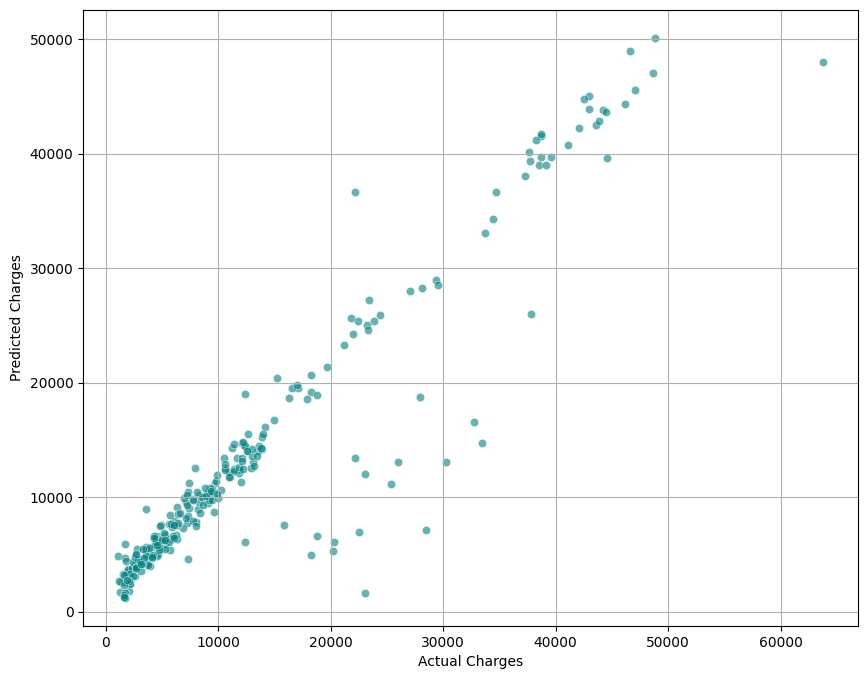

In [12]:
#plot Actual vs predicted

plt.figure(figsize=(10,8))

sns.scatterplot(x=y_test,y=y_pred,alpha=0.6,color='teal')

plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")

plt.grid(True)
plt.show()

In [13]:
# 6. Cross Validation
cv_scores=cross_val_score(final_model,X_train,y_train,cv=4,scoring='neg_mean_squared_error',n_jobs=-1)
cv_rmse=np.sqrt(-cv_scores)

print(cv_rmse)
print(cv_rmse.mean())
print(cv_rmse.std())

[4672.26240084 4167.33653925 4807.45399678 5060.14404329]
4676.799245041921
325.4215458600336


In [14]:
# comparison between predict and actual max, min
xx=y_pred
xy=y_test
print(xx.max(),xy.max())
print(xx.min(),xy.min())

50126.80650797299 63770.42801
1209.2160448293089 1131.5066


In [15]:
# 7. Hyper Parameter Tuning:

param_grid={
    'model__n_estimators':[100,200,300] ,
    'model__max_depth': [3,5,7,9,11],
    'model__learning_rate':[0.01,0.05,0.1,0.15,0.2,0.5]
}

best_model_obj = models['Gradient Boosting']


selected_model=Pipeline([
    ('preprocessor', preprocessor),
    ('model',best_model_obj)
])

grid_search=GridSearchCV(
    estimator=selected_model,
    param_grid=param_grid,
    cv=5 ,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    verbose=2
)

grid_search.fit(X_train,y_train)
print(-grid_search.best_score_)
print(grid_search.best_params_)

Fitting 5 folds for each of 90 candidates, totalling 450 fits
4629.586003072301
{'model__learning_rate': 0.05, 'model__max_depth': 3, 'model__n_estimators': 100}


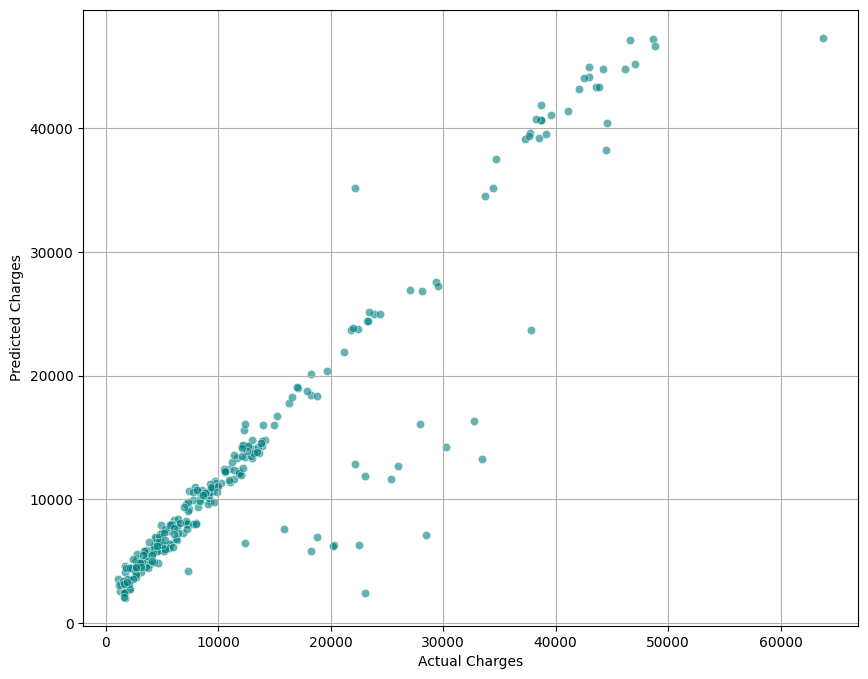

47302.180289384116 63770.42801
2049.0851205502418 1131.5066


In [16]:
# 8. Best Model Selection

y_pred=grid_search.predict(X_test)
plt.figure(figsize=(10,8))

sns.scatterplot(x=y_test,y=y_pred,alpha=0.6,color='teal')

plt.xlabel("Actual Charges")
plt.ylabel("Predicted Charges")

plt.grid(True)
plt.show()

# comparison between predict and actual max, min
xx=y_pred
xy=y_test
print(xx.max(),xy.max())
print(xx.min(),xy.min())

In [17]:
# 9. model performance evaluation

r2=r2_score(y_test,y_pred)
rmse=np.sqrt(mean_squared_error(y_test,y_pred))
mae=mean_absolute_error(y_test,y_pred)

print("R2 Score: ",r2)
print("RMSE Score: ",rmse)
print("MAE Score: ",mae)

R2 Score:  0.8813499268226092
RMSE Score:  4291.884592133859
MAE Score:  2415.5574957822873


In [18]:
import pickle

with open("Medical_Charges_model.pkl", "wb") as f:
    pickle.dump(grid_search, f)